# Defining the SI Model

we consider a Probabilistic Cellular Automata (PCA) model
for the diffusive spread of a news item [(adapting a toy example for Interactive Markov Chains)](https://www.tandfonline.com/doi/abs/10.1080/0022250X.1976.9989852). 

Using the [PCA framework](https://link.springer.com/book/10.1007/978-3-319-65558-1), we define:



- The Graph $G$ to be a 2D lattice of $(K,K)$ regular cells
- The Alphabet $S:= \{0,1\}$

This means, we have a square grid of cells, where each cell can either be 1 (infected) or 0 (not infected)

torch.Size([1, 9, 9])


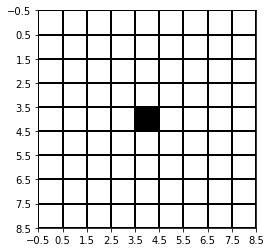

In [54]:
import numpy as np
from model import init_grids
import matplotlib.pyplot as plt

batch = init_grids(size=9, batch_size=1)
print(batch.shape)

plt.imshow(batch.squeeze(), cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
plt.grid(color='black', linewidth=2)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 9.5, 1))
ax.set_yticks(np.arange(-.5, 9.5, 1))
plt.show()

- A periodic Torus wrapping around the PCA

In order to handle the border conditions of the CA, we will define a continuous torus by periodically wrapping around the border of the CA. E.g., for a $(K, K)$-sized CA, the neighbor of cell $(0,3)$ will be cell 
$(K-1,3)$. Equivalently, for cell $(2,0)$, the left neighbor would be $(2,K-1)$.


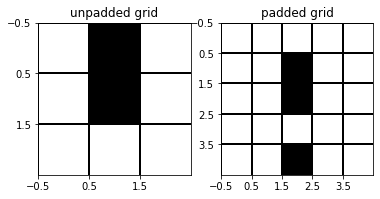

In [49]:
from periodic_padding import periodic_padding

grids = init_grids(size=3, batch_size=1)
grids[0,0,1] = 1

padded_grids = periodic_padding(grids)

fig, axs = plt.subplots(1,2)
axs[0].imshow(grids.squeeze(), cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
axs[0].set(title="unpadded grid")
axs[0].grid(color='black', linewidth=2)
axs[0].set_xticks(np.arange(-.5, 2.5, 1))
axs[0].set_yticks(np.arange(-.5, 2.5, 1))
axs[1].imshow(padded_grids.squeeze(), cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
axs[1].set(title="padded grid")
extent = (0, padded_grids.shape[2], padded_grids.shape[2], 0)
axs[1].grid(color='black', linewidth=2)
axs[1].set_xticks(np.arange(-.5, 4., 1))
axs[1].set_yticks(np.arange(-.5, 4., 1))
plt.show()

- The neighborhood $V_k$ of cell $k$ is the square Moore neighborhood with distance 1:

This means that we consider every cell that is touching either an edge or a corner of cell $(i,j)$ to be its' neighbor.

The PCA simulates the spread of the news over time. To do that, we consider a timeframe of $T$ discrete timesteps. At each timestep $t$, the probability of reaching a configuration $\sigma_{t+1} \in S^{K\times K}$ from a current configuration $\sigma_{t} \in S^{K\times K}$ is:

$$P(\sigma_{t+1} | \sigma_t) = \prod_{k \in G} p(\sigma_{t+1}^k|\sigma_t^{V_k})$$

Where we define $p(\sigma_{t+1}^k|\sigma_t^{V_k})$, the probability of cell $k$ transitioning to state $\sigma_{t+1}^k$ given the state of its' neighborhood $\sigma_t^{V_k}$ as:

$$p(\sigma_{t+1}^k|\sigma_t^{V_k}) = \begin{pmatrix}
1 & 1-(1-\beta)^{N_k(n)} \\
0 & (1-\beta)^{N_k(n)}
\end{pmatrix}$$

The probability matrix represents, that once a person is aware of the news, they stay aware ($p_{11} = 1$, $p_{21}=0$). The probability, with which an uninformed person stays uninformed at time $n+1$ depends on the amount of local neighbors that are informed at time $n$, $N_k(n)$. Given a rate of spread $\beta$ (the diffusion coefficient), the probability to stay unaware is $p_{22}= (1-\beta)^{N_k(n)}$. Conversely, the probability that the news spread to cell $k$ is $p_{21} = 1 - p_{22} = 1-(1-\beta)^{N_k(n)}$.

### 2. Defining a Convolution that finds the number of active neighbors for each cell

The update of cell $k$ depends on the configuration of it's neighborhood $\mu_{V_k}$. More directly, we care about the number of active (state=1) neighbors of
cell $k$. To find the amount, we can simply apply a $3\times3$ convolution onto $k$ with the following kernel:

$$F(\mu_{V_k}) = \begin{pmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 
\end{pmatrix} \circledast \mu_{V_k}$$

### 3. Defining a function to calculate the likelihood of the news item spreading to a cell

We get the likelihood of each cell being activated as:

$$p(\sigma=1|\mu_{V_k})=1-(1-\beta)^{F(\mu_{V_k})}$$

resulting in a $(K,K)$ matrix, where each entry $(i,j)$ corresponds to the probability of the cell at the lattice coordinates $i,j$ being activated.

### 4. Defining a differentiable approximation of the heaviside step-function

$$H(x) \approx \frac{1}{2} + \frac{1}{2}\text{tanh}(kx) = \frac{1}{1+e^{-2kx}}$$

